<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install joblib
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math

from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')


In [0]:
#FEATURES AND LABELS  

#LDR 
with open('/content/labelsFinal_withprevpm.bin','rb') as file:
  labels = pickle.load(file)
  
  
with open('/content/featuresFinal_withprevpm.bin','rb') as file:
  features = pickle.load(file)

In [3]:
print(np.shape(features))

(2471, 10)


In [0]:
# features =[]
# for i in temp:
#   features.append(list(i))

# labels=[]  
# for i in l:
#   labels.append(list(i))

In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
with open('/content/x_test.bin','wb') as file:
  pickle.dump(x_test_t, file)
with open('/content/y_test.bin','wb') as file:
  pickle.dump(y_test_t, file)

In [6]:
print(np.shape(y_test_t))

(742, 1)


In [0]:
tf.reset_default_graph()

In [8]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12327881736787191976
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14161389971015644770
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16965243525475737986
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15898936901980270331
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:

from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(15, input_shape = (10, ), activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1,  activation = 'relu'))

Using TensorFlow backend.
W0821 17:16:54.335856 140407976343424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 17:16:54.342470 140407976343424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 17:16:54.346426 140407976343424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
#tf.keras.losses.Huber(delta=0.4)
model.compile(optimizer = Adam(lr = 0.001),loss='mse')
model.summary()

W0821 17:16:54.427633 140407976343424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit([x_train_t], [y_train_t], validation_split = 0.33, epochs = 300, verbose = 1, batch_size = 32, shuffle = True)

In [0]:
tr = hist.history['loss']
val_ls = hist.history['val_loss']
plt.plot(tr[1:])
plt.plot(val_ls[1:])

In [0]:
predicted = model.predict([x_test_t])


In [0]:
print(np.shape(y_test_t))
y_test_t=np.reshape(y_test_t, (np.shape(y_test_t)[0],1))
print(np.shape(predicted))

(147, 1)
(147, 1)


In [0]:
# print(np.shape(y_test_t))
##print(np.shape(predicted))

actual =[]
pred=[]
se=0
show = np.hstack((y_test_t, predicted))

for i in show:
  se+=(i[0]-i[1])**2
  actual.append(i[0])
  pred.append(i[1])
  
 




In [0]:
rmse = (se/np.size(y_test_t))**0.5

In [0]:
print(rmse)

11.004678821178647


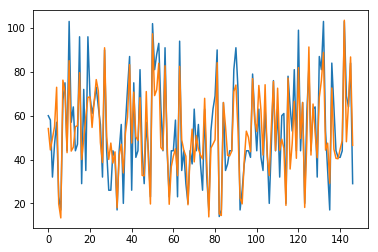

In [0]:
plt.plot(actual)
plt.plot(pred)

In [9]:
print(np.shape(labels))

(2471, 1)


In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(shape = (None,10), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

#Layer 1 
w1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((10, 15))), name = 'w1')
b1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,15))), name = 'b1')

#Layer2 

w2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((15,25))), name = 'w2')
b2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,25))), name = 'b2')

#out

wo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((25,1))), name = 'wo')
bo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,1))), name = 'bo')


In [0]:
hidl1 = tf.add(tf.matmul(x,w1),b1, name ='hidden1')
hidl1 = tf.nn.relu(hidl1)
hidl2 = tf.add(tf.matmul(hidl1,w2),b2, name = 'hidden2')
hidl2 = tf.nn.relu(hidl2)

In [0]:
#outl_batch = tf.compat.v1.layers.batch_normalization(hidl2)
out = tf.add(tf.matmul(hidl2,wo),bo,name = 'output')


In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,out))) 

opt = tf.train.AdamOptimizer(name = 'optimizer', learning_rate=0.005)
op_train = opt.minimize(loss, name ='train_op')

  

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

4846.207	4324.442
3337.246	3583.9617
3932.0605	2752.1802
4608.7285	3504.7524
4318.8994	2584.919
3208.2026	2496.085
2793.372	3481.2605
2335.023	2158.858
1972.4109	2356.4521
4254.823	3072.6074
1651.6147	3168.8977
3568.6116	4002.121
2966.1033	1928.2874
5646.7607	4527.216
2128.644	2554.2842
4357.7925	3036.6177
2138.991	2101.6807
2708.9888	2307.7576
2450.5278	2624.7275
2553.3472	2227.2517
2636.1147	1983.1097
2604.3696	2822.9812
1456.31	2059.121
1521.8525	3353.338
1940.8262	1819.2512
1720.8066	1918.6764
2311.245	3223.9438
1473.8019	1129.1082
1456.3131	2789.6873
3086.3176	1746.1212
1495.5385	1342.9303
1457.3518	3456.6768
1230.864	931.09393
2348.789	3278.815
1837.1274	1642.991
743.66583	1070.6138
1649.1073	506.41608
1070.3335	759.889
2287.5002	1951.0256
532.0291	1406.1902
1878.6729	2651.4058
1310.792	507.16815
889.2582	1123.3682
660.37085	721.61914
1918.6104	648.24976
440.8944	1899.2346
524.90106	930.7444
1729.7195	1515.4509
632.1634	1789.6394
1097.8241	995.1493
1534.0286	1143.1025
896.5405	91

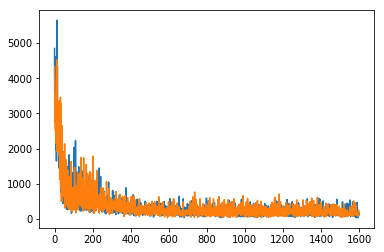

In [26]:

train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    #saved.restore(sess, "/content/final_check_weights.ckpt")
    mini =[]
    for i in range(1600):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    save_path = save.save(sess, "/content/check_weight.ckpt")
    print('Saved model!')
    
 

In [27]:
print(z)

[170.82608, None, []]


In [28]:
print(type(tf.get_default_graph().as_graph_def()))
tf.io.write_graph(tf.get_default_graph().as_graph_def(), '/content/', 'FINAL_GRAPH.pbtxt')

<class 'tensorflow.core.framework.graph_pb2.GraphDef'>


'/content/FINAL_GRAPH.pbtxt'

In [0]:
with open('/content/FINAL_GRAPH.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())
  

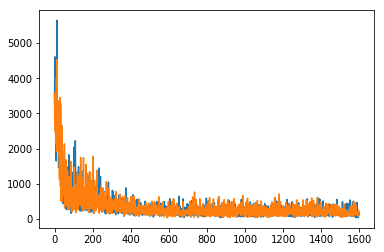

In [30]:
plt.plot(train[1:])
plt.plot(val[1:])

In [31]:
tf.trainable_variables()

[<tf.Variable 'w1:0' shape=(10, 15) dtype=float32_ref>,
 <tf.Variable 'b1:0' shape=(1, 15) dtype=float32_ref>,
 <tf.Variable 'w2:0' shape=(15, 25) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(1, 25) dtype=float32_ref>,
 <tf.Variable 'wo:0' shape=(25, 1) dtype=float32_ref>,
 <tf.Variable 'bo:0' shape=(1, 1) dtype=float32_ref>]

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''